In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import riesling as rl

# Introduction
This demo will go through the basic funcionality in `riesling` using a phantom example. `riesling` will be executed as a commandline tool and basic methods for integration with python are demonstrated as well.

The following commands are available in `riesling`

In [2]:
!riesling -h

  riesling COMMAND {OPTIONS}

    RIESLING

  OPTIONS:

      COMMANDS
        admm                              ADMM recon
        blend                             Blend basis images
        cg                                cgSENSE/Iterative recon w/ Töplitz
                                          embedding
        compress                          Apply channel compression
        espirit                           Create SENSE maps with ESPIRiT
        grid                              Grid from/to non-cartesian to/from
                                          cartesian
        hdr                               Print the header from an HD5 file
        lookup                            Basis dictionary lookup
        meta                              Print meta-data entries
        nii                               Convert h5 to nifti
        nufft                             Apply forward/reverse NUFFT
        phantom                           Construct a digitial phantom
     

Before we begin, it is worth cleaning the working directory of existing `.h5` files. Sometimes if there is an error while an `.h5` is open, subsequent attempts to write to that file will fail and cause havoc.

In [3]:
!rm tut*.h5

The commands will be exectued without verbose mode on here to reduce stdout output, but if you want to get a better idea of what is happening, add `-v`. If you want even more info set `--verbosity 1/2/3`, at the highest level you will get intermediate image files saved as well, such as iterations in iterative methods.

## Table of contents

- [1. Generate a phantom](#gen_phantom)
- [2. The H5 format](#h5_hdr_data_traj)
    - [2.1 Look at the raw data, header, and trajectory using riesling](#h5_riesling)
    - [2.2 Import the data into python](#h5_python)
- [3. Root sum of squares reconstruction](#rss_recon)
- [4. SENSE Reconstruction](#sense_recon)
    - [4.1 Coil compression](#coil_compress)
- [5. Iterative Reconstruction](#iterative_recon)
    - [5.1 Conjugate Gradients](#cg_sense)
    - [5.2 Total Generalised Variation](#tgv)
- [6. Gridding methods](#gridding_methods)



<a href='gen_phantom'></a>
## 1. Generate a Phantom

We start by generating a 3D Shepp Logan phantom which will be used for this demonstration. We use a 

- `mat`: Matrix size of 128 which results in a nominal number of spokes $N_{nom} = MAT^2\cdot \pi=51471$. In `riesling` we assume a factor of $\pi$ undersampling is fully sampled. We therefore ignore this factor. 
- `srate`: We undersample in the angular direction by $\pi$ and an additional 25%.
- `lrate`: Scale factor for gradient amplitude in low-resolution spokes for filling deadtime gap. Will also set the number of low-res spokes.
- `snr`: SNR of 50
- `gap`: Dead-time gap of 3


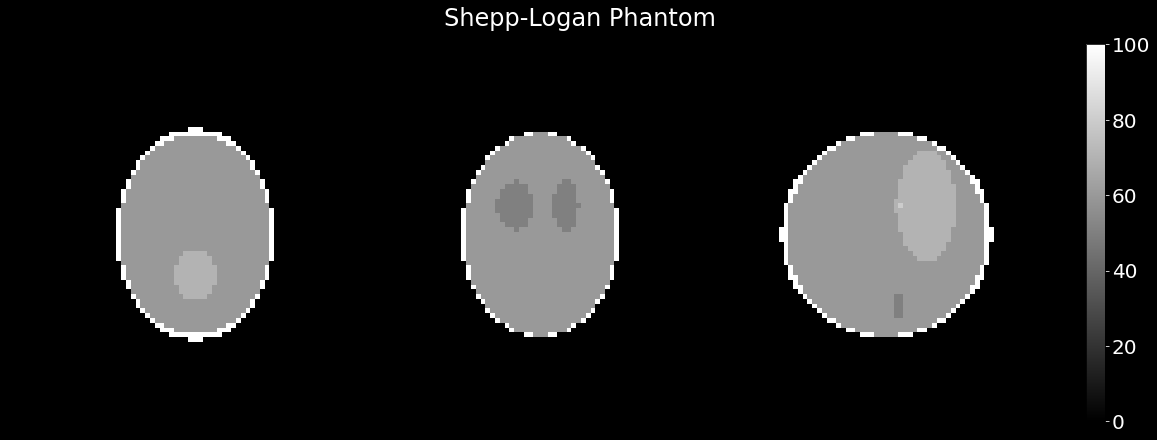

In [4]:
mat=64
snr = 50
nchan = 4
!riesling phantom tut --shepp_logan --matrix={mat} --snr={snr} --channels={nchan}
display(rl.images.single('tut.h5', dset='phantom', title='Shepp-Logan Phantom', clim=[0,100]))

**Note!** `riesling` utilise the FFTW library to calculate FFTs. FFTW uses a planner function to optimise the FFT calculation for your system and different data structures. The first time you calculate a new FFT you will therefore notice a longer computational time. The next time it will be a lot faster! `riesling` provides a `plan` command that will plan the necessary FFTs for a particular trajectory, because the trajectory is only saved once the phantom is created.

This will create a file called `sl_phantom.h5` which contains the radial k-space data, the header information, and the trajectory. 

To do a simple reconstruction we use the `recon` command with the `--rss` (root-sum-squares) option. The default output format is also `.h5`, which we will use throughout this tutorial. To ouput nifti instead, specify `--oft=nii`

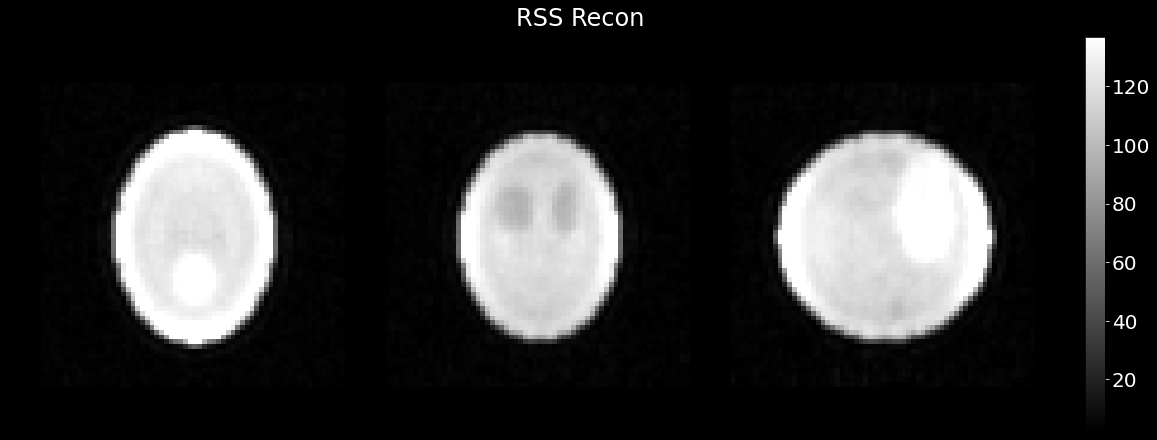

In [5]:
!riesling recon --rss --sdc=pipenn tut.h5
rl.images.single('tut-recon.h5', title='RSS Recon')

<a href='h5_hdr_data_traj'></a>
## 2. H5 format - Header, Data, Trajectory
The `.h5` format used in `riesling` is a simple data structure containing the radial k-space data, trajectory and meta data. Below we demonstrate how to look at the data structure using `riesling` and then with python.


<a href='h5_riesling'></a>
### 2.1 Using `riesling`
You can inspect the `h5` file using the `hdr` command

In [6]:
!riesling hdr tut.h5

Type: 3D
Matrix: 64 64 64
Channels: 4 Read points: 64 Spokes: 4096
Volumes: 1 Echoes: 1
Voxel-size: 3.75 3.75 3.75	 TR: 1	 Origin: -120 -120 -120
Direction:
1 0 0
0 1 0
0 0 1


The `traj` command can be used to grid your data for inspection and also calculate the point spread function. The trajectory will be weighted by the number of samples at each Cartesian grid-point. We can see here that with the Pipe method the correct even weighting of k-space is achieved. The slice through the equator k-space has few samples on the left-hand side due to specific Archimedean spiral used for the trajectory. For a similar reason, the point-spread function shows some aliasing in the polar directions. 

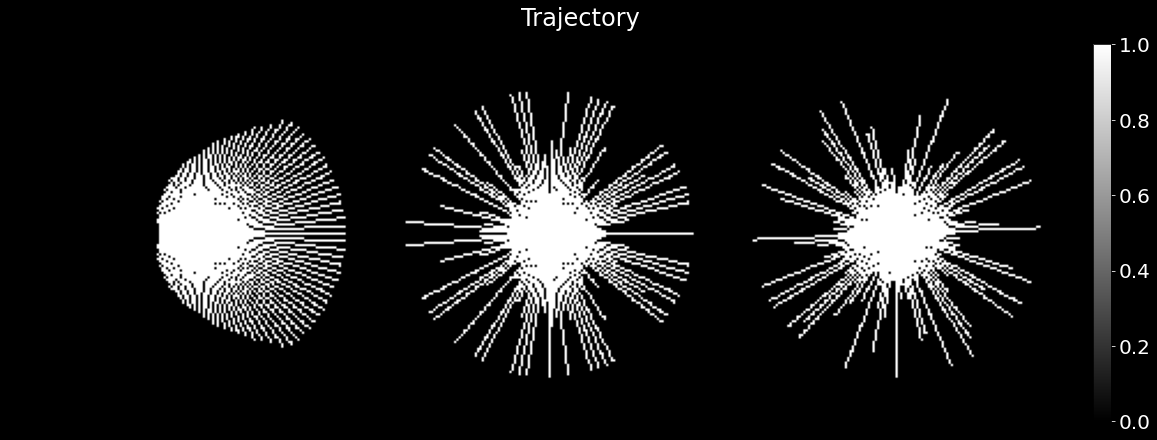

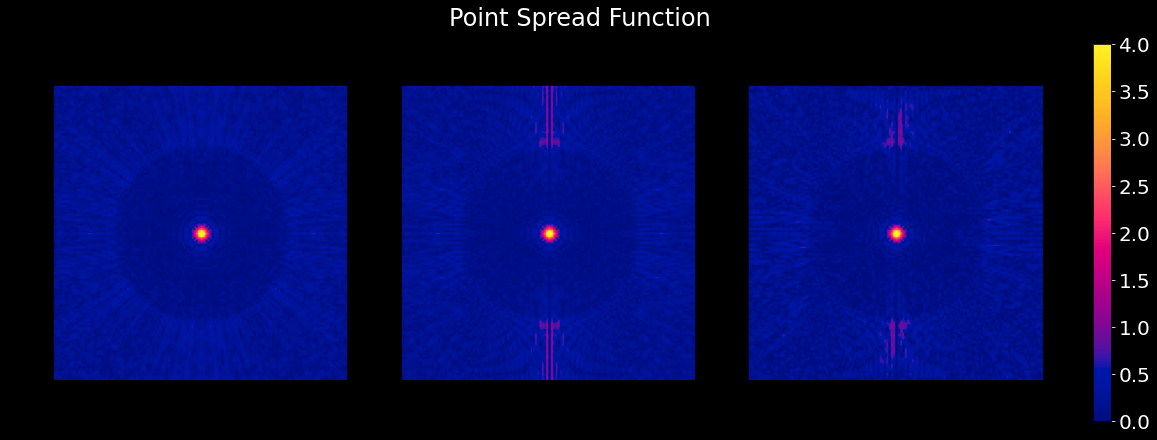

In [7]:
!riesling traj --sdc=pipenn --psf tut.h5
display(rl.images.single('tut-traj.h5', title='Trajectory', dset='traj-image'))
display(rl.images.single('tut-traj.h5', title='Point Spread Function', dset='psf-image', comp='log', cmap='cet_bmy', clim=(0,4)))

<a href='sdc'></a>
### 2.2 Saving Sample Densities
You may have noticed that up to now we have added the `--sdc=pipe` option to the command-line. Density Compensation is very important for fast 3D reconstructions. The [Pipe and Menon](https://onlinelibrary.wiley.com/doi/10.1002/(SICI)1522-2594(199901)41:1%3C179::AID-MRM25%3E3.0.CO;2-V) method is actually the default, but has been added to the command-line for clarity so far.

Although estimating the sample densities is fairly quick, they are constant for any given trajectory. Hence `riesling` allows you to calculate them once and then re-use them, with the `sdc` command. We will now do this and use the saved densities for the remaining reconstructions. The output filename will be `input-sdc.h5` and can be loaded with `--sdc=input-sdc.h5`.

There is a separate notebook (`sdc.ipynb`) to illustrate how important SDC is for 3D radial trajectories.

In [8]:
!riesling sdc --sdc=pipenn tut.h5

<a id='h5_python'></a>
### 2.3 Read radial h5 file into python
In some cases you might want to look at the raw data yourself in python for debugging or to do other recon. Since we use a standard HDF5 file it is easy to read in the data using the `h5py` library. The `info` structure is a numpy array where each entry has a special datatype with an associated name and data format. You can access elements using the names like a dictionary. The trajectory is a numpy array with order [spokes, readout, dimension]. The data is stored such that, if you like to, you can access it through hyperslabs. Here we read in all of it at once. It has the shape of [1, spokes, readout, coils].

It is good practice to open an h5 file in a `with:` block. `hypy` will keep files open on disk until the `File` object goes out of scope, which will prevent the files being overwritten.

In [9]:
import h5py
with h5py.File("tut.h5",'r') as f:
    print(f.keys())
    info = f['info'][:]
    for k in info.dtype.names:
        print("{}: {}".format(k, info[k]))
    trajectory = f['trajectory'][:]
    print("Trajectory shape: {}".format(trajectory.shape))
    data = f['noncartesian'][:]
    print("Data shape: {}".format(data.shape))

<KeysViewHDF5 ['echoes', 'info', 'noncartesian', 'phantom', 'trajectory']>
matrix: [[64 64 64]]
voxel_size: [[3.75 3.75 3.75]]
read_points: [64]
spokes: [4096]
channels: [4]
type: [1]
volumes: [1]
echoes: [1]
tr: [1.]
origin: [[-120. -120. -120.]]
direction: [[1. 0. 0. 0. 1. 0. 0. 0. 1.]]
Trajectory shape: (4096, 64, 3)
Data shape: (1, 4096, 64, 4)


Let's have a look at the trajectory, and the data both in non-cartesian space and on the cartesian grid.

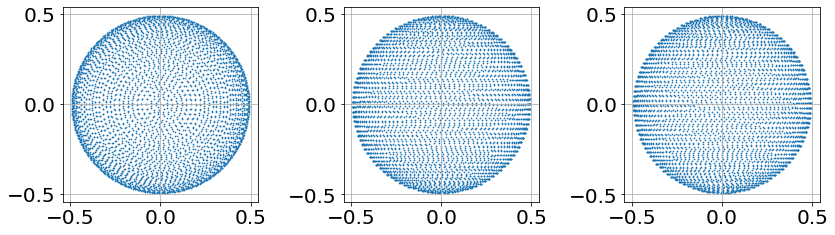

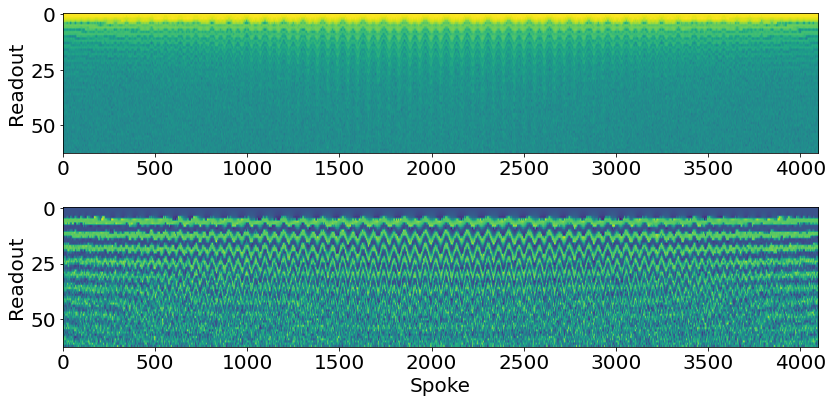

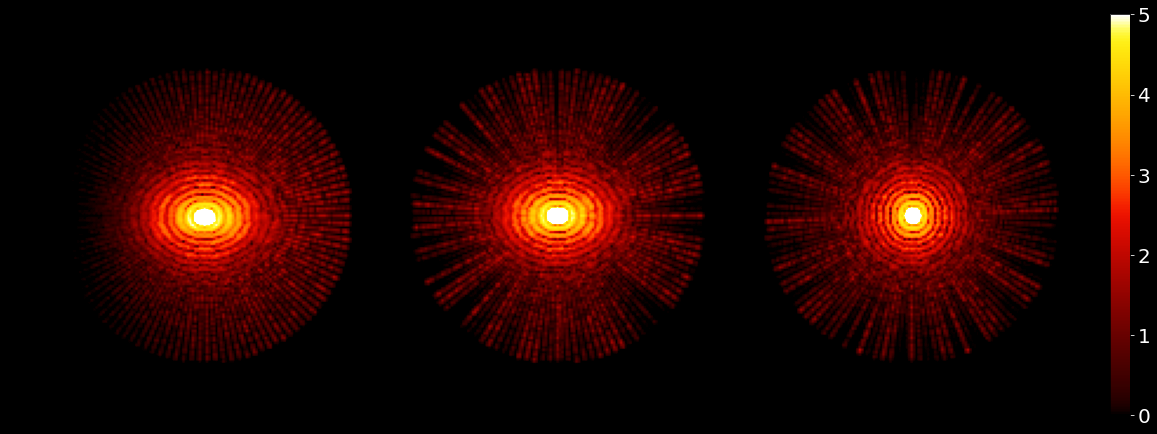

In [10]:
display(rl.plots.traj2d('tut.h5', sl_read=-1))
display(rl.plots.kspace('tut.h5',sl_spoke=slice(0,4096),coil=0))
!riesling grid tut.h5 --sdc=tut-sdc.h5 --kernel=KB3
display(rl.images.grid('tut-grid.h5', dset='cartesian', clim=(0, 5), cmap='cet_fire', ic=0))

In both the trajectory and data plotted here we see the low-resolution spokes acquired in the beginning which are used to fill the deadtime gap. Note that for the low-resolution spokes the k-space trajectory is still scaled between -1.0 and 1.0 - `riesling` will apply the `lo_scale` value in the header information to transform these points.

<a id='sense_recon'></a>
## 3. SENSE Reconstruction
Above we did a simple RSS reconstruction. The next step is to do a SENSE reconstruction where we estimate coil sensitivity maps and do a complex coil combination. The `recon` command automatically estimate sensitivities if you do not specify the `--rss` option using the method of [Yeh et al](http://doi.wiley.com/10.1002/mrm.20517). However, if you want to see the sensitivities, or will be applying the same sensitivities to multiple images, then you can use the `sense` command first to save them.

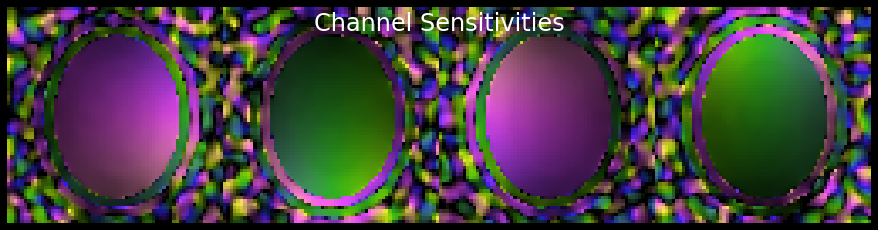

In [11]:
!riesling sense --sdc=tut-sdc.h5 tut.h5
rl.images.sense('tut-sense.h5', title='Channel Sensitivities')

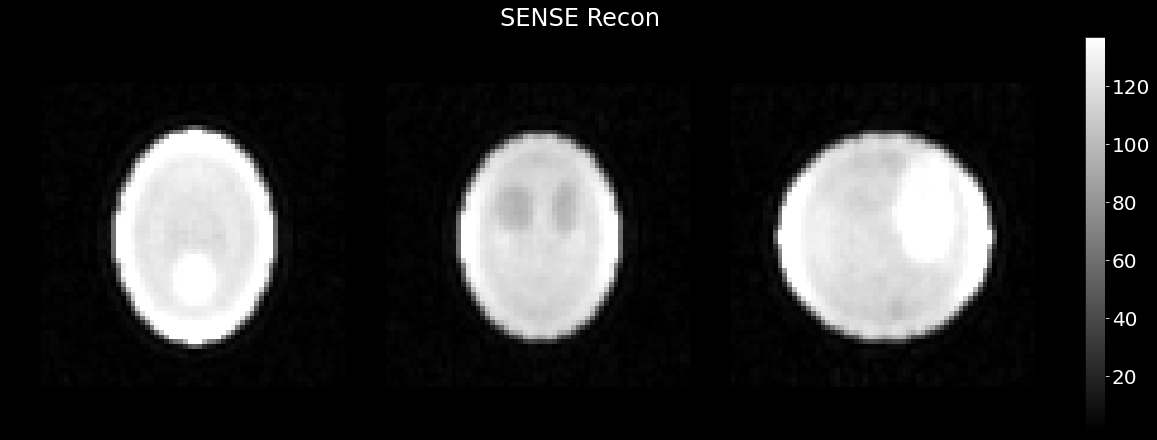

In [12]:
!riesling recon --sense=tut-sense.h5 --sdc=tut-sdc.h5 tut.h5
# display(rl.images.slices('tut-channels.h5', title='Channel Images'))
display(rl.images.single('tut-recon.h5', title='SENSE Recon'))

<a id='iterative_recon'></a>
## 5. Iterative Reconstruction
For iterative recon we have two options, conjugate-gradient sense (in `cg`) or total generalised variation (in `tgv`). Both these methods have the `-i` option to decide the number of interations. Note that these methods are computationally heavy and we use few iterations here as a proof of concept.

An important point to note is that the iterative methods use an expanded field-of-view during the iterations before cropping to the final FoV. This means the sensitivities we created earlier can't be used as they have the wrong FoV. We can generate a new set with a matching FoV - the default iteration FoV is 256 mm.

In [13]:
!riesling sense --sdc=tut-sdc.h5 tut.h5 --fov=256 -o iter

<a id='cg_sense'></a>
### 5.1 Conjugate Gradients - CG-SENSE
The conjugate gradient method is a popular reconstruction method which recently was highlighted in the [2020 Reproducibility Studygroup reconstruction challenge](https://onlinelibrary.wiley.com/doi/10.1002/mrm.28569). This will make the image sharper but also introduce noise and some aliasing/ringing artefacts.

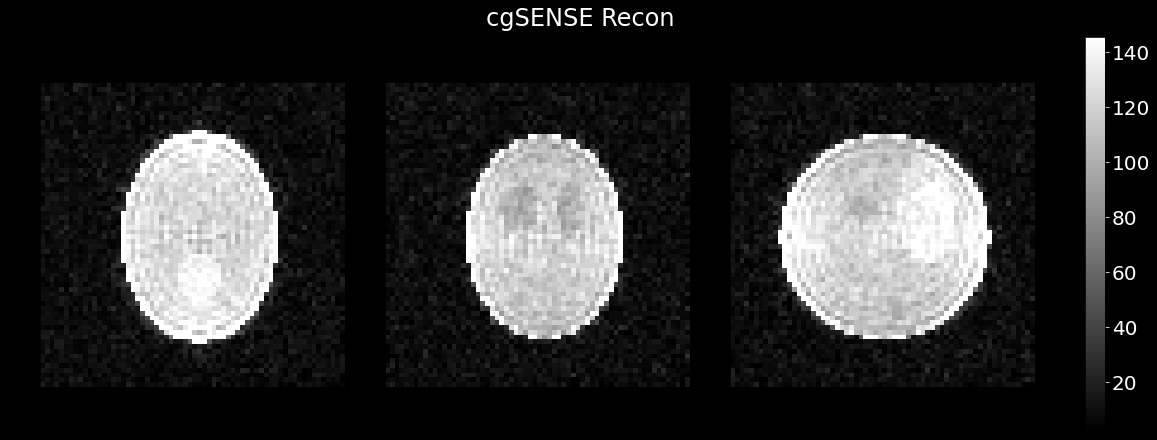

In [14]:
!riesling cg -i 5 --sense=iter-sense.h5 --sdc=tut-sdc.h5 tut.h5 --max_its=4
rl.images.single('tut-cg.h5', title='cgSENSE Recon')

<a id='tgv'></a>
### 5.2 TGV
For the TGV method there are several additional parameters which sets the level of regularisation, which allows balancing the level of sharpness and noise. 

- `--l1`: $L_1$ Regularisation weighting (Default $10^{-5}$
- `--l1reduce`: Reduce $L_1$ by factor over iteations (suggested 0.1)
- `--step`: Inverse of step size (default 8)

It is likely you will have to tweak these parameters to get the best result for your application.

TGV will take longer than the other recon methods to run.

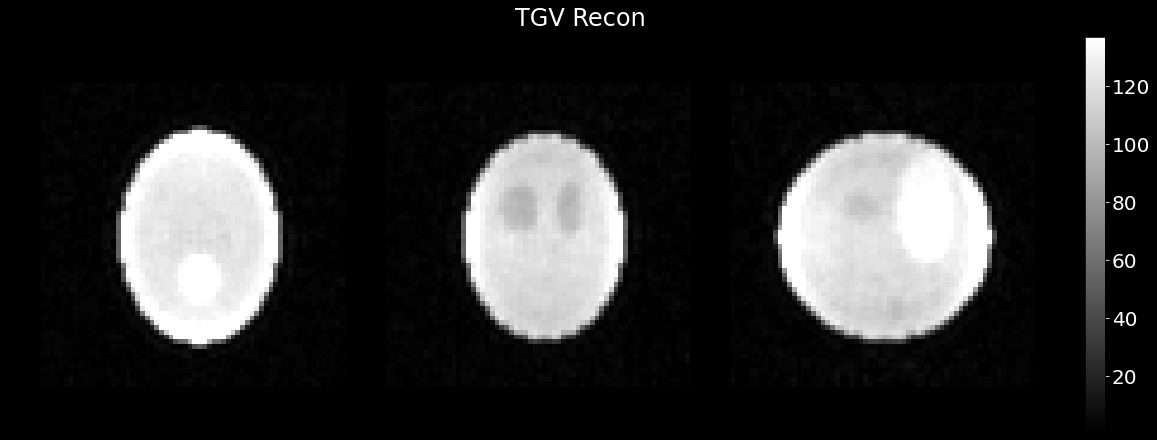

In [15]:
!riesling tgv -i 10 --sense=iter-sense.h5 --sdc=tut-sdc.h5 tut.h5 --alpha 2E-5
rl.images.single('tut-tgv.h5', title='TGV Recon')

<a id='gridding_methods'></a>
## 6. Gridding Methods
All reconstruction tools in `riesling` include two different gridding methods

- Nearest-Neighbor, aka. NN, (Default) - [Oesterle et al. 1999](https://onlinelibrary.wiley.com/doi/10.1002/(SICI)1522-2586(199907)10:1%3C84::AID-JMRI12%3E3.0.CO;2-D)
- Kaiser-Bessel kernel width 3 (`--kb`) - [Beatty et al. 2005](https://ieeexplore.ieee.org/document/1435541)

For 3D reconstructions, NN gridding works very well and gives very similar results to KB. The initial gridding step is much faster with NN, but for a `cg` reconstruction due to Töplitz embedding the full reconstruction time should be similar.

In [16]:
!time `riesling cg --sense=iter-sense.h5 --toe --sdc=tut-sdc.h5 -i 5 --kernel=NN tut.h5 -o tut-NN`

In [17]:
!time `riesling cg --sense=iter-sense.h5 --toe --sdc=tut-sdc.h5 -i 5 --kernel=KB3 tut.h5 -o tut-KB`

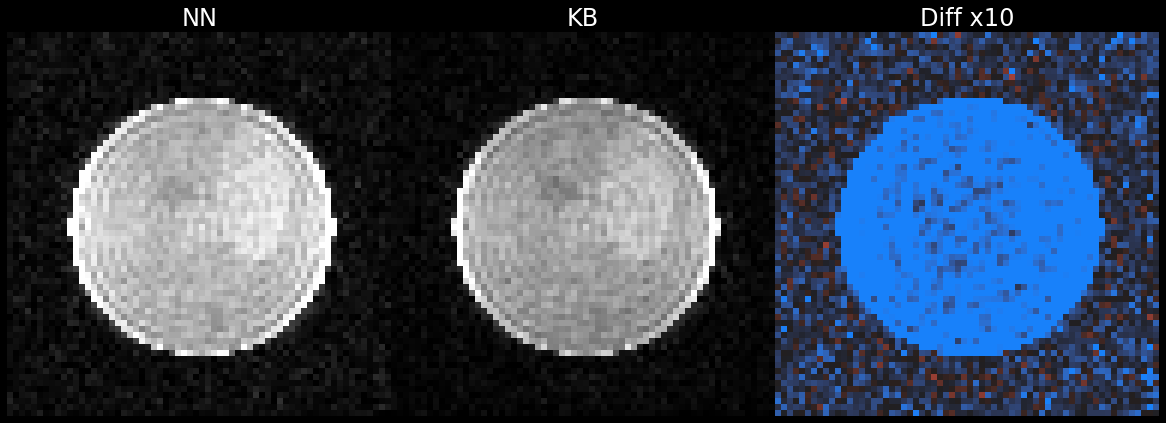

In [18]:
rl.images.diff('tut-NN-cg.h5', 'tut-KB-cg.h5', title1='NN', title2='KB', diffscale=10)